# Generics

In this topic we are going to explore new concepts such reified type parameters and declaration-site variance.

_Refied type parameters_ allow us to refer at runtime to the specific types used as type arguments in an inline function call.

_Declaration-site variance_ lets us specify whether a generic type with a type argument is a subtype or a supertype of another generic type with the same base type and a different type of argument. For example, it regulates whether it's possible to pass arguement of type `List<Int>` to function expecting `List<Any>`.

## Generic Functions and Properties

Lets say we want to write a function that work with a list, we want it to work with any list, not just a list of elements of a specific type and for that we need to write a generic function.


### Generic Function Declaration

<img src="../resources/generic-example-1.png"/>


The function's type parameter T is used in the receiver type and in the return type; both of them are List<T>. 

In [ ]:
val authors = listOf("Dmitry", "Svetlana")
val readers = mutableListOf<String>()

fun <T> List<T>.filter(predicate: (T) -> Boolean ): List<T>

readers.filter { it !in authors }

In the above example the type of the autogenerated lambda parameter it is String in this case. The compiler has to infer that: after all, in the declaration of the function, the lambda parameters has a generic type T (it's the type of the function arguement in (T) -> Boolean). The compiler understand that T is String, because it knows the function should be called on List<T>, and the actual type of its receiver, readers, is List<String>

### Declaring generic classes

We declare a generic class in kotlin by putting angle brackets after the class name and the type parameters in the angle brackets. Once we do thatm we can use the type parameters in the body of the class, just like any other types.

``` kotlin
interface List<T> {
    operator fun get(index: Int) : T
}
```


If our class extends a generic class (or implements a generic interface), we have to provide a type argument for the generic parameter of the base type. It can be either a specific type or another type parameter:

``` kotlin
class StringList: List<String> {
    override fun get(index: Int): String =  ...
}

class ArrayList<T>: List<T> {
    override fun get(index: Int): T = 
}
```


### Type parameter constraint

_Type Parameter Constraints_ as the name suggest let us restrict the types that can be used as type arguments for a class or function. For example, consider a function that calculates the sum of elements in a list.it can be used on a `List<Int>` or a `List<Double>`, but not, for example, a `List<String>`. To express this, you can define a type parameter constraint that specifies that the type parameter of `sum` must be a number

<img src="../resources/generic-example-2.png"/>

The actual type argument should extend `Number` to allow this function invocation

Once we specified a bound for a type parameter T, we can use values to type T as values of its upper bound.

In [2]:
fun <T: Number> oneHalf(value: T): Double {
    return value.toDouble() / 2.0
}

println(oneHalf(3))

1.5


Lets write a generic function that finds the maximum of two items. Because its possible to find a maximum of items that can be compared to each other, we need to specify that in the signature of the function.

In [3]:
fun <T: Comparable<T>> max(first: T, second: T): T {
    return if (first > second) first else second
}

println(max("kotlin", "java"))

kotlin


In the rare case when we need to specify multiple constraints on a type parameter, we can a slightly different syntax

In [4]:
fun <T> ensureTrailingPeriod(seq: T)
    where T: CharSequence, T: Appendable {
        if(!seq.endsWith('.')){
            seq.append('.')
        }
}

### Making type parametes non-null

If you declare a generic class or function, any types, including nullable ones, can be substituted for its type parameters.

In [5]:
class Processor<T>{
    fun process(value: T){
        value?.hashCode()
    }
}

In the process function, the parameter value is nullable, even though T isn't marked with a question mark. This is the case because specific instantiations of the Processor class can use a nullable type of T:

In [6]:
val nullableStringProcessor = Processor<String?>()
nullableStringProcessor.process(null)

If we want to guarantee that a non-null type will always be substituted for a type parameter, we can achieve this by specifying a constraint.

``` kotlin
class Processor<T: Any> {
    fun process(value: T){
        value.hashCode()
    }
}
```

## GENERICS AT RUNTIME: ERASED AND REIFEID TYPE PARAMETRS

### Generics at runtime: type checks and casts

Kotlin's generics are erased at runtime. this means an instance of generic class doesn't carry information about the type arguements used to create that instance For example, if you create a List<String> and put a bunch of strings into it, at runtime you’ll only be able to see that it’s a List. It’s not possible to identify which type of elements the list was intended to contain. (Of course, you can get an element and check its type, but that won’t give you any guarantees, because other elements may have slightly different types.

In [6]:
val value: List<String> = listOf("a", "b")
val list2: List<Int> = listOf(1, 2, 3)

if (value is List<Int>){
    println("Value is List of String")
}

Cannot check for instance of erased type: List<Int>

Even though  it's perfectly possible to find out at runtime that value is a List, but we can't tell whether its a list of Person or a String.

To check whether a given variable is a List not Set or something else we can use

In [7]:
if (value is List<*>){
    println("Value is a list")
}

Value is a list


We can still use normal generic types in as and as? cast. But the cast won't fail if the class has the correct base type and wrong type arguement because the type arguement isn't known at runtime when the cast is performed.

In [10]:
fun printSum(c: Collection<*>){
    val intList = c as? List<Int>
        ?: throw IllegalArgumentException("List is expected")
        
    println(intList.sum())
}

printSum(listOf(1,2,3))
printSum(listOf("a","b","c"))

6


java.lang.ClassCastException: java.lang.String cannot be cast to java.lang.Number
kotlin.collections.CollectionsKt___CollectionsKt.sumOfInt(_Collections.kt:2474)
Line_10_jupyter.printSum(Line_10.jupyter.kts:5)
Line_10_jupyter.<init>(Line_10.jupyter.kts:9)
sun.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
sun.reflect.NativeConstructorAccessorImpl.newInstance(Unknown Source)
sun.reflect.DelegatingConstructorAccessorImpl.newInstance(Unknown Source)
java.lang.reflect.Constructor.newInstance(Unknown Source)
kotlin.script.experimental.jvm.BasicJvmScriptEvaluator.evalWithConfigAndOtherScriptsResults(BasicJvmScriptEvaluator.kt:95)
kotlin.script.experimental.jvm.BasicJvmScriptEvaluator.invoke$suspendImpl(BasicJvmScriptEvaluator.kt:40)
kotlin.script.experimental.jvm.BasicJvmScriptEvaluator.invoke(BasicJvmScriptEvaluator.kt)
kotlin.script.experimental.jvmhost.repl.JvmReplEvaluator$eval$$inlined$write$lambda$2.invokeSuspend(legacyReplEvaluation.kt:57)
kotlin.coroutines.jvm.inte

You don’t get an IllegalArgumentException, because you can’t check whether the argument is a List<Int>. Therefore the cast succeeds, and the function sum is called on such a list anyway. Although it’s executed, an exception is thrown. This happens because the function tries to get Number values from the list and add them together. An attempt to use a String as a Number results in a ClassCastException at runtime.

### Declaring Function With Reified Type Parameters

Kotlin generics are erased at runtime, which means if you have an instance of a generic class, you can't find out the type arguements used when the instance was created. The same holds for type arguement of a function when we call a generic function in its body we cannot find the type arguements it was invoked with.

``` kotlin
fun <T> isA(value: Any) = value is T
Error: Cannot check for instance of erased type
```

This is true in general, But there is one case where this limitation can be avoided: inline functions. Type parameters of inline function can be reified, which means we can refer to actual type arguement at runtime

If we declare the above function as inline and mark the type parameter as reified, we can check the value to see whether it's an instance of T:

In [2]:
inline fun <reified T> isA(value: Any) = value is T

println(isA<String>("abc"))

true


One of the simplest examples where reified type parameters come into play is the filterIsInstance standary library function which takes a collection and select instances of the specified class and return only those instances.

``` kotlin
val items = listOf("one", 2, "three")
println(items.filterIsInstance<String>())
```

In [3]:
inline fun <reified T> Iterable<*>.filterIsInstance(): List<T> {
    val destination = mutableListOf<T>()
    for (element in this){
        if (element is T){
            destination.add(element)
        }
    }
    return destination
}

### Why reification works for inline function only?

The compiler inserts the bytecode implementing the inline function into every place where it's called, Everytime we call the function with reified type parameter, the compiler knows the exact type used as the type arguement in the particular call. Therefore, the compiler can generate the bytecode that references the specific class used as type argument.

An inline function can have multiple reified type parameters, and it can also have non-reified type parameters in addition to the reified ones. 

To ensure good performance, you still need to keep track of the size of the function marked as inline. If the function becomes large, it’s better to extract the code that doesn’t depend on the reified type parameters into separate non-inline functions.

### Replacing class references with reified type parameters

One common use case for reified type parameters is building adapters for APIs that take parameters of type java.lang.Class. An example of such an API is ServiceLoader from the JDK, which takes a java.lang.Class representing an interface or an abstract class and returns an instance of a service class implementing that interface. Let’s look at how you can use reified type parameters to make those APIs simpler to call.

``` kotlin
val serviceImpl = ServiceLoader.load(Service::class.java)
```

Now let's rewrite this example using a function with a reified type parameter:
``` kotlin
val serviceImpl = loadService<Service>()
```

As you can see it is much shorter to call and much easier to read.

Let's see how this `loadService` function can be defined

In [ ]:
inline fun <reified T> loadService() {
    return ServiceLoader.load(T::class.java)
}

In [ ]:
// Simplifying the startActivity function on Android
inline fun <reified T : Activity> Context.startActivity() {
    val intent = Intent(this, T::class.java)
    startActivity(intent)
}

## Variance: Generics and Subtyping

The concept of variance describes how types with same base type and different type arguements relate to each other: for example, `List<String> and List<Any>`

Understanding variance is important when we write our own generic classes or funciton: it helps us to create API's that don't restrict user in inconvenient ways and don't break their type-safery expectation

In [6]:
fun addAnswer(list: MutableList<Any>) {
    list.add(42)
}

val strings = mutableListOf("abc", "bac")
addAnswer(strings)

Type mismatch: inferred type is MutableList<String> but MutableList<Any> was expected

You declare a variable strings of type `MutableList<String>`. Then you try to pass it to the function. If the compiler accepted it, you’d be able to add an integer to a list of strings, which would then lead to a runtime exception when you tried to access the contents of the list as strings. Because of that, this call doesn’t compile. This example shows that it’s not safe to pass a `MutableList<String>` as an argument when a `MutableList<Any>` is expected; the Kotlin compiler correctly forbids that.

### Classes, Types and Subtyping

We sometimes used the terms type and class as equivalent, but they aren't. In the simplest case with non-generic class, the name of the class can be used directly as the type but the story become much more complicated with the `Generic` types.

The story becomes even more complicated with generic classes. To get a valid type, you have to substitute a specific type for the class type parameter.

List is not a type its a class, but all of the following substitutions are valid types: `List<Int>`, `List<String?>`, 
`List<List<String>>` and so on. Each generic type produces a potenitally infinite number of types.


### Sub Type

In order to discuss the relation between types, we need to be familiar with the term _subtype_. Type B is a subtype of a type A if we can use the value of the type B whenever a value of the type A is required. For example, Int is a subtype of Number, but Int is not a subtype of String.

``` kotlin
fun test(i: Int){
    // Compiles because int is a subtype of number
    val n: Number = i
    
    // Doesn't compiles because Int isn't subtype of String
    fun f(s: String){}
    f(i)
}
```

In Simple cases, a subtype means essentially the same thing as subclass. For example, the Int class is a subclass of Number, and therefore the Int type is a subtype of Number type.

Nullable type provides an example of when subtype isn't the same as subclass.  

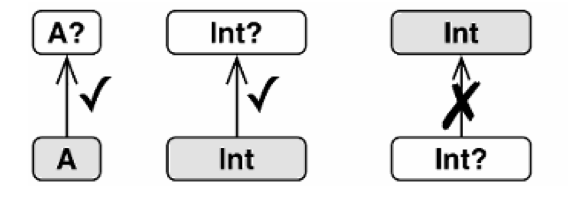

A non-null type is a subtype of its nullable version, but they both correspond to one class. You can always store the values of a non-null type in a variable of a nullable type, but not vice-versa.


### Covariance: preserved subtyping relation

A covariant class is a generic class for which the following holds: `Producer<A>` is a subtype of `Producer<B>` if A is a subtype of B.

In kotlin, to declare the class to be covariant on a certain type parameter, we put the `out` keyword before the name of the type parameter:

``` kotlin
interface Producer<out T> {
    fun produce(): T
}
```

Marking a type parameter of a class as covaraint makes it possible to pass value of that class as function parameter and return values when **the type arguement don't exactly match the ones in the function definition**.

For example, imagine a function that takes care of feeding a group of animals, represented by the Herd class. The type parameter of the Herd class identifies the type of the animal in the herd.

In [18]:
open class Animal {
    fun feed(){
     println("feed")   
    }
}

class Herd <T: Animal> {
    val animals = arrayListOf<T>()
    val size: Int get() = animals.size
    operator fun get(i: Int): T{
        return animals[i]
    }
}

fun feedAll(animals: Herd<Animal>){
    for (i in 0 until animals.size) {
        animals[i].feed()
    }
}

class Cat: Animal() {
    fun cleanLitter() {
        
    }
}

fun takeCareOfCats(cats: Herd<Cat>) {
    for (i in 0 until cats.size){
        cats[i].cleanLitter()
        feedAll(cats)
    }
}

Type mismatch: inferred type is Line_18_jupyter.Herd<Line_18_jupyter.Cat> but Line_18_jupyter.Herd<Line_18_jupyter.Animal> was expected

Unfortunately, the cats will remain hungry. We don't use any variance annotation on the T type parameter in the Herd class, the herd of cats isn't a subclass of the herd of animals. we could use an explicit cast to work around the problem, but that approach is verbose, error-prone, and almost never a correct way to deal with a type-mismatch problem

In [22]:
class Herd<out T: Animal>{
    val animals = listOf<T>()
    val size: Int get() = animals.size
    operator fun get(i: Int): T{
        return animals[i]
    }
}
fun feedAll(animals: Herd<Animal>){
    for (i in 0 until animals.size) {
        animals[i].feed()
    }
}

fun takeCareOfCats(cats: Herd<Cat>) {
    for(i in 0 until cats.size){
        cats[i].cleanLitter()
    }
    feedAll(cats)
}

To guarantee type safety, it can be used only in `out` positions, meaning the class can give out value of type T but not take them in.

Let’s consider a class that declares a type parameter T and contains a function that uses T. We say that if T is used as the return type of a function, it’s in out position. In this case, the function produces (outputs) values of type T. If T is used as the type of a function parameter, it’s in in position. Such a function consumes values of type T.

![generic-example-4.png](attachment:generic-example-4.png)

The `out` keyword on a type parameter of the class requires that all the methods using T have T only in out position and not in `in` position

Note that you can’t declare `MutableList<T>` as covariant on its type parameter, because it contains methods that take values of type T as parameters and returning such values (therefore, T appears in both in and out positions)

**Constructor parameter are in neither the `in` nor `out` position. So even the type parameter is declared as out, we can still use it in a constructor parameter declaration**

``` kotlin
class Herd<out T: Animal>(vararg animals: T)
```

If you use the val or var keyword with a constructor parameter, however, you also declare a getter and a setter (if the property is mutable). Therefore, the type parameter is used in and out position for a read-only property and in both out and in positions for a mutable property:

``` kotlin
class Herd<T: Animal>(var leadAnimal: T, vararg animals: T)
```

In this case T can't be marked as out, because the class contains a setter for the leadAnimal property that uses T in `in` position

The position rules cover only the externally visible (public and protected) API of a class, Parameters of private methods are in neither `in` nor `out` position. The variance rules protect a class from misuse by external clients and don't come into play in the implementation of the class itself.

``` kotlin
    class Herd<out T: Animal>(private var leadAnimal: T, vararg animals: T){
}
```

Now it's safe to make Herd covariant on T, because the leadAnimal property has been made private.

### Contravariance: reversed subtyping relation

The concept of contravariance is dual to covariance: for a contravariantclass, the subtyping relation is the opposite of the subtyping relations of classes used as its type arguements.

Lets look at the Comparator interface. this interface defines one method, `compare`, which compares two given objects:

As we can see that the method of this interface only consumes value of type T. That means T is used only in `in` positions, and therefore its declaration can be preceded by the `in` keyword


``` kotlin
interface Comparator<in T> {
    fun compare(e1: T, e2: T): Int
}

val anyComparator = Comparator<Any> {
    e1,e2 -> e1.hashCode() - e2.hashCode()
    

val strings: List<String>

string.sortedWith(anyComparator)
}
```

The sortedWith function expects a `Comparator<String>` (a comparator that can compare strings), and it’s safe to pass one that can compare more general types. If you need to perform comparisons on objects of a certain type, you can use a comparator that handles either that type or any of its supertypes. This means `Comparator<Any>` is a subtype of `Comparator<String>`, where Any is a supertype of String. The subtyping relation between comparators for two different types goes in the opposite direction of the subtyping relation between those types.


A class that is contravariant on the type parameter is a generic class (let’s consider `Consumer<T>` as an example) for which the following holds: `Consumer<A>` is a subtype of `Consumer<B>` if A is a supertype of B.The type arguments A and B changed places, so we say the subtyping is reversed. For example, `Consumner<Animal>` is a subtype of `Consumer<Cat>`

A class or interface can be covariant on one type parameter and contravariant on another. The classic example is the Function interface.

``` kotlin
interface Function1<in P, out R> {
    operator fun invoke(p: P): R
}
```

The Kotlin notation (P) -> R is another, more readable form to express Function1<P, R>. You can see that P (the parameter type) is used only in in position and is marked with the in keyword, whereas R (the return type) is used only in out position and is marked with the out keyword. That means the subtyping for the function type is reversed for its first type argument and preserved for the second. For example, if you have a higher-order function that tries to enumerate your cats, you can pass a lambda enumerating any animals.

``` kotlin
fun enumerateCats(f: (Cat) -> Number)
fun Animal.getIndex(): Int

enumerateCats(Animal::getIndex)
```

Above code is legal in kotlin. Animal is a supertype of Cat, and Int is a subtype of Number.


### Use-site variance: specifying variance for type occurences

The ability to specify variance annotations on class declarations
because the annotation is applied to all the places where the class is used. this is called _declaration-site variance_

Although in java everytime we use a type with a type parameter, we can specify whether this type parameter can be replaced with its subtypes or supertypes. This is called use-site variance
               

true